# Test the ENC-DEC model

In [1]:
import dataloader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import os
import time
from torch_geometric.nn import GATv2Conv, global_mean_pool
# reload library
import importlib
import cv2
import utils as ut
import pandas as pd

In [2]:
importlib.reload(dataloader)
importlib.reload(models)

NameError: name 'importlib' is not defined

## Load Behavoiur

In [5]:
file = r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\behaviour\DMD\male male\Complete\DMD_mal_Test_2.csv'
behaviour = pd.read_csv(file)
behaviour

,Frame,contacts generaux (R + V) active,sniff total resident active,redressement R active,grooming R active,sniff total V active,Grooming V active,Redressement V active,grooming retest V active,Dominance V active,Poursuit V active
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2632,2632,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2633,2633,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2634,2634,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2635,2635,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**GENERAL**

In [6]:
import pandas as pd
file = r't:\Julián\DMD NULL BEHAVIOR\male male\GENERAL\SITDMDnull_male_male_GENERAL\TestDataReport_SIT_DMD_null_male_male_Test_1.csv'
behaviour = pd.read_csv(file)
behaviour

FileNotFoundError: [Errno 2] No such file or directory: 't:\\Julián\\DMD NULL BEHAVIOR\\male male\\GENERAL\\SITDMDnull_male_male_GENERAL\\TestDataReport_SIT_DMD_null_male_male_Test_1.csv'

**DOM_POUR_RESIDENT**

In [ ]:

file = r't:\Julián\DMD NULL BEHAVIOR\male male\VISITEUR\SITDMDnull_male_male_Dominance_poursuit_VISITEUR\SITDMDnull_male_male_Dominance_poursuit_VISITEUR_test_1.csv'
behaviour = pd.read_csv(file)
behaviour

**CON_GROOM_REAR_RESIDENT**

In [ ]:
file = r't:\Julián\DMD NULL BEHAVIOR\male male\VISITEUR\SITDMDnull_male_male_Contact_grooming_rearing_VISITEUR\SITDMDnull_male_male_Contact_grooming_rearing_VISITEUR_test_1.csv'
behaviour = pd.read_csv(file)
behaviour

### Load data

In [4]:
importlib.reload(dataloader)
importlib.reload(models)
import pandas as pd

In [5]:

data_dlc = dataloader.DataDLC(r'C:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\DataLoaderTestFormat\DMD_mal_Test 1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5')
#data_dlc.coords.iloc[:,]

ImportError: Missing optional dependency 'pytables'.  Use pip or conda to install pytables.

---

**Try the function to plot periodogram**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
x_time_serie_nose = data_dlc.coords.iloc[:,0]
y_time_serie_nose = data_dlc.coords.iloc[:,1]


In [ ]:
ARIMA_model = ARIMA(x_time_serie_nose, order=(1,0,1))
ARIMA_model_fit = ARIMA_model.fit()
ARIMA_model_fit.summary()


In [ ]:

# See fitted model 
plt.plot(x_time_serie_nose, color='blue')
plt.plot(ARIMA_model_fit.fittedvalues, color='red', linestyle='--')
plt.show()


In [ ]:
# Plot differences
plt.plot(ARIMA_model_fit.resid, color='green')
plt.show()


In [ ]:
# Get places where the residuals are higher than 3 std
residuals = ARIMA_model_fit.resid
std = residuals.std()
outliers = np.where(np.abs(residuals) > 3*std)[0]
outliers

for outlier in outliers:
    # plot a window of 10 frames around the outlier
    plt.plot(x_time_serie_nose[outlier-10:outlier+10], color='blue', label='Original')
    plt.plot(ARIMA_model_fit.fittedvalues[outlier-10:outlier+10], color='red', linestyle='--', label='Fitted')
    # plot a circle around the outlier
    plt.scatter(outlier, x_time_serie_nose[outlier], color='green', s=100, label='Outlier', alpha=0.5)
    plt.legend()
    plt.show()


In [ ]:
# Plot both series
plt.plot(x_time_serie_nose, label='x')
plt.plot()

In [ ]:
data_dlc.coords.isna().sum().sum()

---

**This is only to create an eassy graph to test the build_graph_2 function**



In [ ]:
if False:
    data_dlc.coords = data_dlc.coords.iloc[range(3), :]
    data_dlc.n_frames = 3
    data_dlc.save(r'C:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\DataLoaderTestFormat\output1.h5')


## Load dataset

**Obs:** This is just a test to see if the model is working.

In [3]:
data_loader = dataloader.DLCDataLoader(r'C:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\Test_build_graph', batch_size=1, num_workers=0, device='cpu')


Loading data from C:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\Test_build_graph, where we have 32 files
We have 32 files


0it [00:00, ?it/s]

Loading file DMD_mal_Test_1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_2DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_3DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5
Loading file DMD_mal_Test_4DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_5DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5
Loading file DMD_mal_Test_6DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_7DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5
Loading file DMD_mal_Test_8DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_9DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5
Loading file DMD_mal_Test_10DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_11DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_12DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5
Loading file DMD_mal_Test_13DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_14DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5
Loading file DMD_mal_Test_15DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_16DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5
Loading file DMD_mal_Test_17DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_18DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5
Loading file DMD_mal_Test_19DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_20DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5
Loading file DMD_mal_Test_21DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_22DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5
Loading file DMD_mal_Test_23DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_24DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5
Loading file DMD_mal_Test_25DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_26DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5
Loading file DMD_mal_Test_27DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_28DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5
Loading file DMD_mal_Test_29DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_30DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5
Loading file DMD_mal_Test_31DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'x')] = x_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind.loc[:, ('Center of mass', 'y')] = y_mean
c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Code\ENC-DEC\src\dataloader.py:68: SettingWithCopyWarning: 
A value is trying to be se

Loading file DMD_mal_Test_32DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5
Number of files: 32



c:\Users\Usuario\anaconda3\envs\deepof\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [4]:
data_loader.dataset
#Plot the graph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

node_features = data_loader.dataset[0].x.numpy()
edges = data_loader.dataset[0].edge_index.numpy().T


G = nx.Graph()
G.add_nodes_from(range(node_features.shape[0]))
G.add_edges_from(edges)


pos = nx.spring_layout(G)
nx.draw(G, pos, node_color='b', with_labels=True, node_size=300, font_size=8, font_color='w')
plt.show()


AttributeError: 'tuple' object has no attribute 'x'

In [ ]:
# print number of nan values
print(torch.isnan(data_loader.dataset[0].x).sum())

# print number of not nan values
print(torch.isfinite(data_loader.dataset[0].x).sum())

In [ ]:
torch.float64
torch.int64

In [ ]:
importlib.reload(dataloader)
importlib.reload(models)

In [ ]:
graphencoder = models.GATEncoder(nout = 64, nhid=16, attention_hidden=2, n_in=3, dropout=0.5)

In [ ]:
embed = graphencoder.forward(data_loader.dataset[0].x, data_loader.dataset[0].edge_index, data_loader.dataset[0].frame_mask)

In [ ]:
embed.shape

In [ ]:
# print number of nan values
print(torch.isnan(embed[0]).sum())

# print number of not nan values
print(torch.isfinite(embed[0]).sum())

### Graph Classifier

In [ ]:
graphencoder = models.GATEncoder(nout = 64, nhid=16, attention_hidden=2, n_in=3, dropout=0.5)
class_head = models.ClassificationHead(n_latent = 64, nhid=64, nout=2)

In [ ]:
model = models.GraphClassifier(graphencoder, class_head)

In [ ]:
out = model.forward(data_loader.dataset[0].x, data_loader.dataset[0].edge_index, data_loader.dataset[0].frame_mask)

In [ ]:
print(out.shape)

#### Trainning Loop

In [ ]:
# Trainning loop
epochs = 50
lr = 0.005
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    for i, data in enumerate(data_loader):
        optimizer.zero_grad()
        x, edge_index, frame_mask, y = data.x, data.edge_index, data.frame_mask, data.y
        out = model.forward(x, edge_index, frame_mask)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch}, Batch {i}, Loss {loss.item()}')

In [ ]:
out = GraphAE.forward(data_loader.dataset[0].x, data_loader.dataset[0].edge_index, data_loader.dataset[0].frame_mask)

In [ ]:
# Loss and optimizer
loss = GraphAE.loss(data_loader.dataset[0].x, out)

In [ ]:
print(loss)

# Trainning loop

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
encoder = models.GATEncoder(nout = 64, nhid=16, attention_hidden=2, n_in=3, dropout=0.5).to(device)
print(encoder)
decoder = models.GATDecoder(n_latent=64, n_hidden=16, n_out=3).to(device)
print(decoder)
model = models.GraphAE(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
data = data_loader.dataset

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    for i in range(len(data)):

        out = model(data[i].x.to(device), data[i].edge_index.to(device), data[i].frame_mask.to(device))
        loss = model.loss(data[i].x, out)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, Loss {loss.item()}')

model.eval()
out = model(data[0].x, data[0].edge_index, data[0].frame_mask)

In [ ]:
print(out[0][0].shape)

In [ ]:
numpyout = out[0][0].detach().numpy()

In [ ]:
# Plot the output of the model, the first dimension are the points, and the second one is the x and y coordinates
plt.scatter(numpyout[:,0], numpyout[:,1])


In [ ]:
print(data_loader.dataset[0].x.shape)
print(x[0].shape)
print(x[1].shape)

In [ ]:
print(data_loader.dataset[0].x.shape)
print(x[0].shape)
print(x[1].shape)

In [ ]:
contacts = behaviour.iloc[:,1]

---

# Try preprocessing data

In [531]:
importlib.reload(dataloader)

<module 'dataloader' from 'c:\\Users\\Usuario\\Documents\\Documents\\MVA\\Stage\\DLCProject\\Code\\ENC-DEC\\src\\dataloader.py'>

In [532]:
data_path = r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\DataLoaderTrainDataset\DMD_mal_Test_1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5'

data_dlc = dataloader.DataDLC(data_path)

In [533]:
data_dlc.preprocess()

In [534]:
data_dlc.coords.isna().sum().sum()

14512

In [535]:
prev = data_dlc.coords['individual1']['Nose']['x']

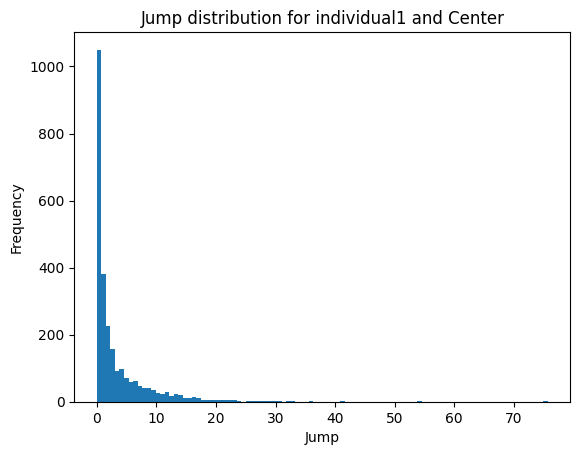

Mean of the jumps for individual1 and Center: 3.334899742684055
Standard deviation of the jumps for individual1 and Center: 5.193917638560763
min 0.0
max 75.72207975220968
mode 0    0.0
dtype: float64
median 1.225711768916589
95 upper percentile 13.763932400524652


In [536]:
diff = data_dlc.get_statistics_on_jumps(plot = True)
print('min', diff.min())
print('max', diff.max())
print('mode', diff.mode())
print('median', diff.median())
print('95 upper percentile', diff.quantile(0.95))

In [537]:

# Deactivate warnings
pd.options.mode.chained_assignment = None  # default='warn'

data_dlc.iterative_jump_detection(threshold_hard=[10000,10000], threshold_soft_min=30, threshold_soft_max=8,  verbose=True, tol=1e-9)
#data_dlc.iterative_jump_detection(verbose=True, tol=1e-9)

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:14,  3.47it/s]

  2%|▏         | 1/50 [00:00<00:28,  1.71it/s]

In [538]:
# See where the jumps are, they are indicated in mask.jumps


In [539]:
# Count trues in mask_jumps
data_dlc.mask_jumps.sum().sum()

9

In [540]:
for ind in data_dlc.individuals:
    for part in data_dlc.body_parts:
        if data_dlc.mask_jumps[ind][part].sum() > 0:
            print('Thers a jump in individual', ind, 'part', part, 'at frames', np.where(data_dlc.mask_jumps[ind][part])[0])
        

Thers a jump in individual individual1 part Left_bhip at frames [949 950]
Thers a jump in individual individual1 part Nose at frames [1110]
Thers a jump in individual individual1 part Tail_1 at frames [ 971 2432]
Thers a jump in individual individual2 part Nose at frames [1656 1890]
Thers a jump in individual individual2 part Right_bhip at frames [366]
Thers a jump in individual individual2 part Tail_tip at frames [118]


In [530]:
data_dlc.remove_outlier_bouts(threshold=200, verbose=True)

KeyboardInterrupt: 

**Check out the mask_jump output**

In [475]:
import matplotlib.pyplot as plt
# Import Arima model
from statsmodels.tsa.arima.model import ARIMA

# MINIC method to detect p and q for ARIMA


In [476]:
# Fit an Arma model with the points where no jumps were detected
coords = data_dlc.coords
mask_jumps = data_dlc.mask_jumps
# Mask_jumps has true where jumps were detected
mask_no_jumps = ~mask_jumps

# Try with 'Nose' x coordinate of 'individual1'
x_time_serie_nose_no_jumps = coords['individual1']['Nose']['x'][mask_no_jumps['individual1']['Nose']]
y_time_serie_nose_no_jumps = coords['individual1']['Nose']['y'][mask_no_jumps['individual1']['Nose']]
x_time_serie_nose_jumps = prev[mask_jumps['individual1']['Nose']]
y_time_serie_nose_jumps = prev[mask_jumps['individual1']['Nose']]



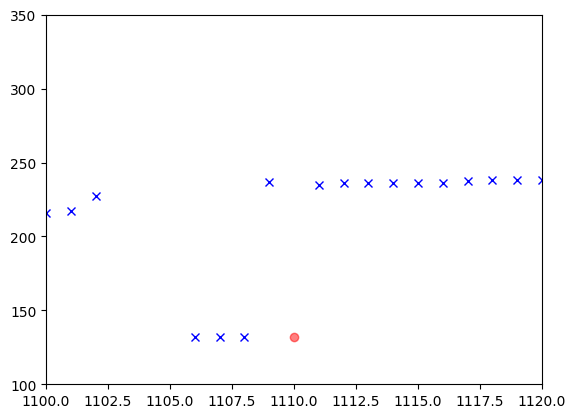

In [481]:
# plot the time series
plt.plot(x_time_serie_nose_no_jumps, color='blue', marker='x', linestyle='')
plt.plot(x_time_serie_nose_jumps, color='red', linestyle='', marker='o', alpha=0.5)
plt.xlim(1100, 1120)
plt.ylim(100,350)
plt.show()


In [407]:
# MINIC method to detect p and q for ARIMA
# Grid search for p and q taking BIC as the metric

# BIC matrix
bic_matrix = pd.DataFrame(index=[f'p={p}' for p in range(1, 6)], columns=[f'q={q}' for q in range(1, 6)])

# Grid search
for p in range(1, 6):
    for q in range(1, 6):
        ARIMA_model = ARIMA(x_time_serie_nose_no_jumps, order=(p,0,q))
        ARIMA_model_fit = ARIMA_model.fit()
        bic_matrix.loc[f'p={p}', f'q={q}'] = ARIMA_model_fit.bic


c:\Users\Usuario\anaconda3\envs\deepof\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Usuario\anaconda3\envs\deepof\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Usuario\anaconda3\envs\deepof\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Usuario\anaconda3\envs\deepof\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Usuario\anaconda3\envs\deepof\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported

In [408]:
bic_matrix

,q=1,q=2,q=3,q=4,q=5
p=1,18201.459564,18069.606955,18041.922741,18019.375733,18004.570555
p=2,17995.309181,17998.14417,18005.989734,18013.166371,18019.415515
p=3,17998.10061,18011.013376,18012.555596,18019.513801,18016.166169
p=4,18006.503588,18012.636166,18018.620636,18026.598998,18024.451529
p=5,18013.031778,18026.108949,18026.289809,18023.636229,18026.687905


In [409]:
bic_matrix = bic_matrix.astype(float)
bic_min = bic_matrix.min().min()
bic_min_idx = bic_matrix.stack().idxmin()
bic_min_idx


('p=2', 'q=1')

In [410]:


# Fit an ARIMA model
ARIMA_model = ARIMA(x_time_serie_nose_no_jumps, order=(0,0,5))
ARIMA_model_fit = ARIMA_model.fit()
ARIMA_model_fit.summary()


c:\Users\Usuario\anaconda3\envs\deepof\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Usuario\anaconda3\envs\deepof\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Usuario\anaconda3\envs\deepof\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Usuario\anaconda3\envs\deepof\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      x   No. Observations:                 2593
Model:                 ARIMA(0, 0, 5)   Log Likelihood              -10917.943
Date:                Mon, 19 Aug 2024   AIC                          21849.886
Time:                        16:18:55   BIC                          21890.910
Sample:                             0   HQIC                         21864.752
                               - 2593                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        242.9067      4.186     58.026      0.000     234.702     251.111
ma.L1          1.8721      0.167     11.206      0.000       1.545       2.200
ma.L2          2.4546      0.149     16.481      0.000       2.163       2.747
ma.L3          2.3317      0.267      8.724      0.000       1.808       2.855
ma.L4          1.5017      0.129     11.616      0.000       1.248       1.755
ma.L5          0.7525      0.127      5.913      0.000       0.503       1.002
sigma2       472.2037     77.415      6.100      0.000     320.473     623.934
===================================================================================
Ljung-Box (L1) (Q):                  82.60   Jarque-Bera (JB):              4439.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [411]:
x_time_serie_nose_jumps

153     411.254
166     538.459
574     218.605
589     122.766
596     190.429
626      72.401
716     288.435
717     286.728
718     286.642
719     286.642
720     286.613
721     286.455
722     286.455
723     286.613
724     287.173
725     287.173
726     287.173
727     283.237
728     282.526
729     281.213
927     202.973
928     253.509
954     263.277
955     181.305
956     265.238
1109    236.882
1110    132.134
1111    234.653
1619     94.048
1621    206.975
1654     69.643
1655    176.770
1656    188.587
1657    183.551
1709     59.933
1716    151.370
1936    465.106
2168    298.173
2620    298.618
Name: x, dtype: float64

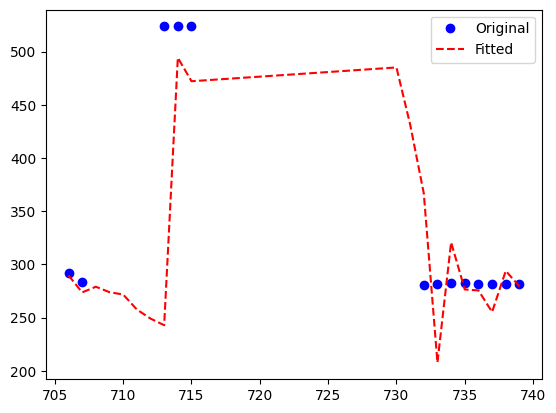

In [412]:
# Plot fitted values
plt.plot(x_time_serie_nose_no_jumps[700:720], color='blue', label='Original', marker = 'o', linestyle='None')
#plt.plot(x_time_serie_nose_jumps, color='green', label='Jumps', marker = 'o', linestyle='None')
plt.plot(ARIMA_model_fit.fittedvalues[700:720], color='red', linestyle='--', label='Fitted')
plt.legend()
plt.show()



In [413]:
ARIMA_model_fit.fittedvalues

0       242.906678
1       430.202342
2       416.977331
3       427.352937
4       433.141716
           ...    
2627    242.567758
2628    329.424008
2629    284.225252
2630    325.404365
2631    312.881332
Length: 2593, dtype: float64

In [414]:
data_dlc.coords['individual2']['Left_ear']['x'].iloc[10:30]

10    470.673
11    472.714
12    474.236
13    475.712
14    475.744
15    477.772
16    480.375
17    481.237
18    481.237
19    481.237
20        NaN
21    463.500
22    463.500
23        NaN
24    457.191
25    455.965
26    451.901
27    444.896
28    432.414
29    418.240
Name: x, dtype: float64

In [415]:
data_dlc.coords.isna().sum().sum()

17399

In [416]:
data_dlc.coords.head(300)

individuals individual1                                                   \
bodyparts          Nose                     Left_ear                       
coords                x        y likelihood        x        y likelihood   
0               452.088  339.107        1.0  506.910  351.021        1.0   
1               454.149  339.107        1.0  507.579  351.237        1.0   
2               455.682  339.107        1.0  507.805  351.306        1.0   
3               454.888  338.197        1.0  507.805  352.206        1.0   
4               454.149  338.186        1.0  507.598  352.731        1.0   
..                  ...      ...        ...      ...      ...        ...   
295             345.737   81.461        1.0  378.046   83.931        1.0   
296             347.156   81.461        1.0  377.981   83.931        1.0   
297             347.828   81.461        1.0  377.981   83.931        1.0   
298             348.164   82.771        1.0  376.487   83.622        1.0   
299             348.164   82.771        1.0  376.335   82.214        1.0   

individuals                                            ... individual2  \
bodyparts   Right_ear                     Center_head  ...      Tail_3   
coords              x        y likelihood           x  ...  likelihood   
0             488.426  323.276        1.0     480.375  ...         1.0   
1             489.853  324.018        1.0     480.375  ...         1.0   
2             490.489  324.018        1.0     481.552  ...         1.0   
3             496.908  323.276        1.0     481.542  ...         1.0   
4             496.908  321.273        1.0     480.573  ...         1.0   
..                ...      ...        ...         ...  ...         ...   
295           392.120   59.202        1.0     369.404  ...         1.0   
296           391.853   57.945        1.0     367.974  ...         1.0   
297           391.853   57.843        1.0     367.974  ...         1.0   
298           391.853   57.843        1.0     367.494  ...         1.0   
299           390.777   57.072        1.0     367.782  ...         1.0   

individuals                                                            \
bodyparts     Tail_4                     Tail_tip                       
coords             x        y likelihood        x        y likelihood   
0            260.278  337.937        1.0  240.202  315.603      1.000   
1            261.650  337.937        1.0  242.000  315.863      1.000   
2            263.745  338.597        1.0  243.666  317.158      1.000   
3            264.364  337.937        1.0  246.715  317.158      1.000   
4            264.364  339.180        1.0  247.814  317.473      1.000   
..               ...      ...        ...      ...      ...        ...   
295          466.369  139.564        1.0  491.086  155.743      0.948   
296          465.208  148.461        1.0  490.319  163.894      1.000   
297          464.974  148.461        1.0  486.374  163.894      1.000   
298          461.049  148.461        1.0  486.374  163.894      1.000   
299          453.519  141.190        1.0  486.374  163.894      0.000   

individuals                                        
bodyparts   Center of mass                         
coords                   x           y likelihood  
0               400.055882  274.051353   1.000000  
1               403.283000  274.373706   0.941176  
2               429.469000  291.834938   1.000000  
3               434.232353  291.951824   0.941176  
4               431.878437  291.240412   0.941176  
..                     ...         ...        ...  
295             301.292647  136.243941   1.000000  
296             300.847824  131.509765   1.000000  
297             300.192941  128.356294   1.000000  
298             299.589412  121.530118   1.000000  
299             296.553118  115.034647   1.000000  

[300 rows x 138 columns]

In [541]:
# Video_path 
video_path = r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\IDtrue-Julian-2024-07-01\videos\DMD_malTest 1.mp4'
video_output_path = r'C:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\Test\video_output3.mp4'

# Create video
data_dlc.create_video(video_path, video_output_path, plot_prev_coords=True, frames = [930, 1120])


  0%|          | 0/190 [00:00<?, ?it/s]

100%|██████████| 190/190 [00:17<00:00, 11.04it/s]


In [160]:
data_dlc.n_body_parts
data_dlc.body_parts

Index(['Center', 'Center_head', 'Left_bhip', 'Left_ear', 'Left_fhip',
       'Left_mid', 'Nose', 'Right_bhip', 'Right_ear', 'Right_fhip',
       'Right_mid', 'Spine_1', 'Spine_1-center', 'Spine_2', 'Spine_2-base',
       'Spine_center-2', 'Tail_1', 'Tail_2', 'Tail_3', 'Tail_4', 'Tail_base',
       'Tail_tip', 'Center of mass'],
      dtype='object', name='bodyparts')

In [161]:


mask_jumps = pd.DataFrame(index=coords.index, columns=coords.columns)
mask_jumps = mask_jumps.astype(bool)
# Set all to false
mask_jumps.loc[:,:] = False
# Order of jumps to analyze
order = 3

# Eliminate drop y and 'likelihood' columns
mask_jumps = mask_jumps.iloc[:,::3]
mask_jumps = mask_jumps.droplevel(2, axis=1)
for ind in data_dlc.individuals:
    for bp in data_dlc.body_parts:
        x = coords[ind].loc[:, (bp, 'x')]
        y = coords[ind].loc[:, (bp, 'y')]
        # Compute the euclidiean difference between two consecutive points and two points separated by two frames
        diff = np.stack ([np.sqrt(np.abs(x.diff())**2 + np.abs(y.diff()**2)), np.sqrt(np.abs(x.diff(-1))**2 + np.abs(y.diff(-1))**2), np.sqrt(np.abs(x.diff(2))**2 + np.abs(y.diff(2))**2)], axis=1)

        # If the jump is higher than threshold pixels, set the mask to true
        mask_jumps.loc[diff[:,0] > 70, (ind, bp)] = True
        mask_jumps.loc[diff[:,1] > 70, (ind, bp)] = True
        # If the jump is higher than threshold pixels and the jump of two frames is higher than 50 pixels, set the mask to true
        mask_jumps.loc[list(set(np.where(diff[:,0]>20)[0]).intersection(set(np.where(diff[:,1]>20)[0])).intersection(set(np.where(diff[:,2]<10)[0]))), (ind, bp)] = True





        

            

In [162]:
diff

array([[        nan,  2.89247767,         nan],
       [ 2.89247767, 23.81562127,         nan],
       [23.81562127,  5.40284305, 26.33748878],
       ...,
       [ 3.5661889 , 11.82387439,  3.48286531],
       [11.82387439, 16.57988825, 10.83472862],
       [16.57988825,         nan, 25.58699399]])

In [328]:
# Plot a window of 10 frames around the jump
ind = 'individual1'
bp = 'Nose'
jumps = mask_jumps[(ind, bp)]

jumps.value_counts()





False    2591
True       41
Name: (individual1, Nose), dtype: int64

posx and posy should be finite values
posx and posy should be finite values


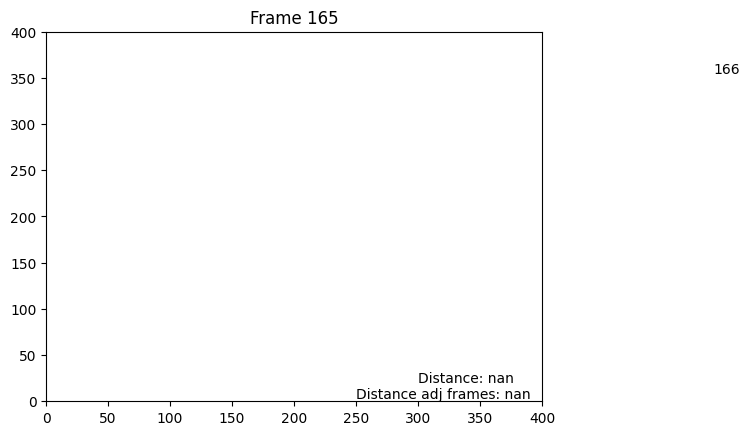

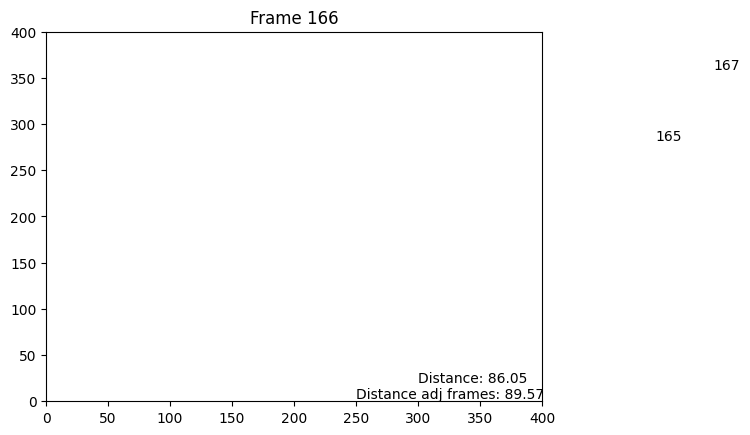

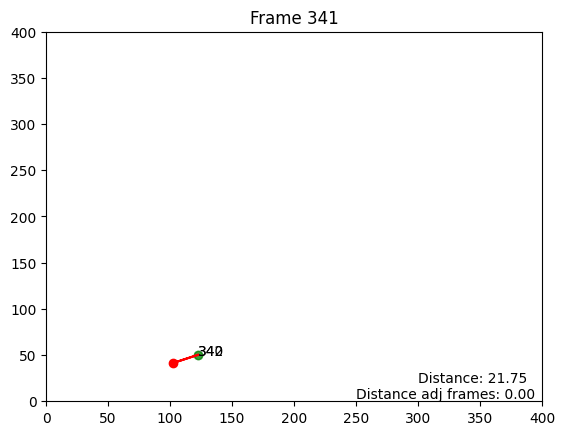

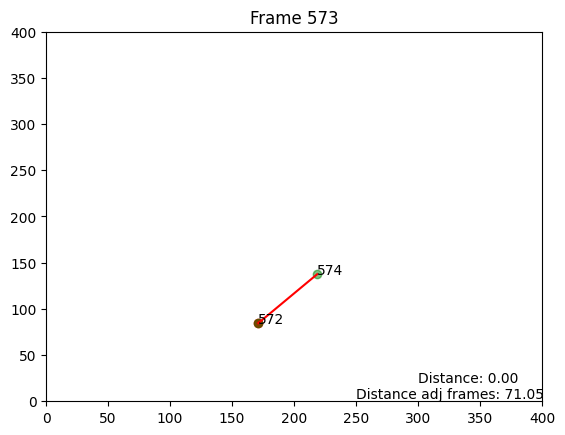

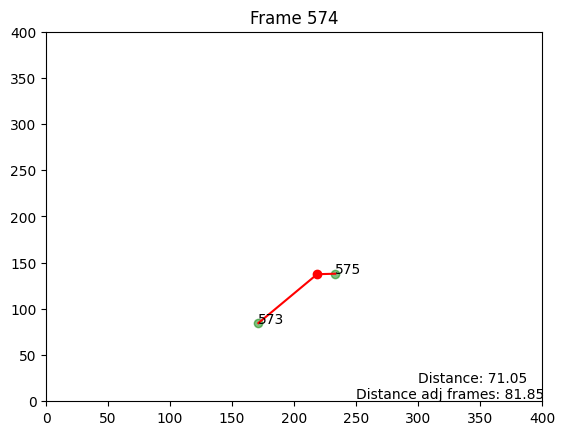

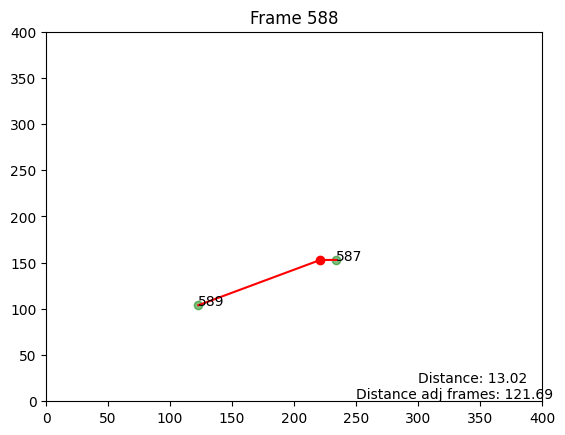

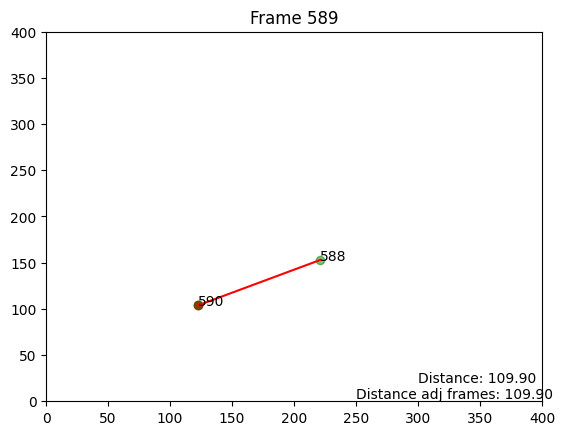

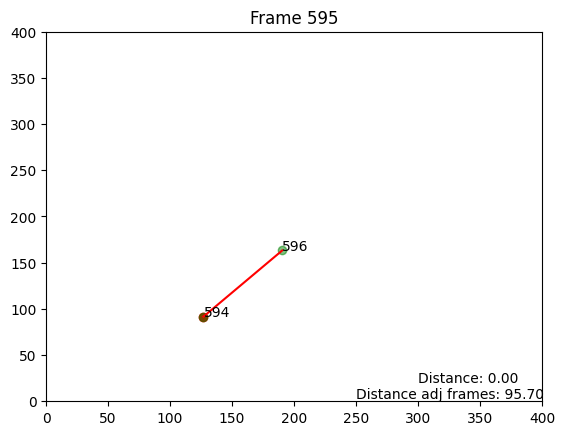

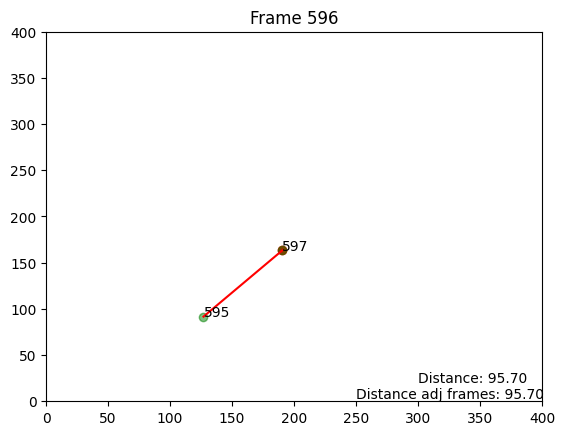

posx and posy should be finite values
posx and posy should be finite values


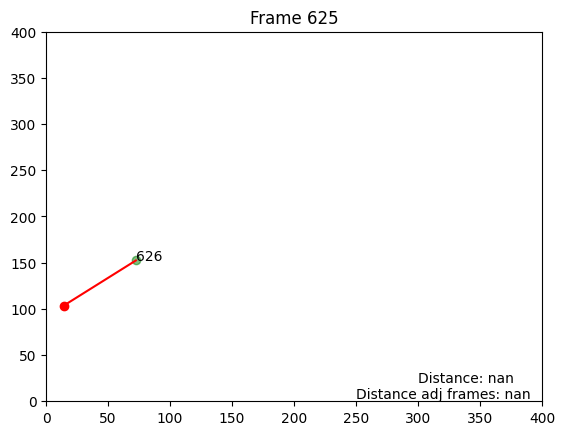

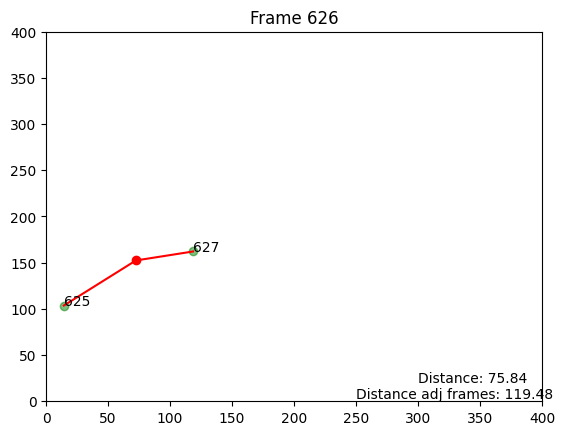

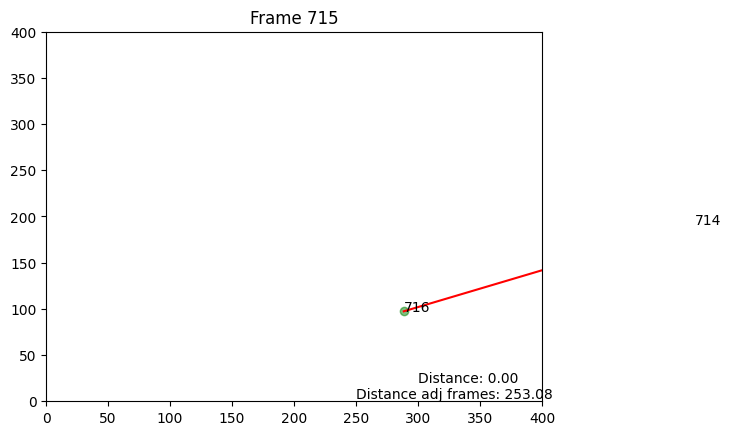

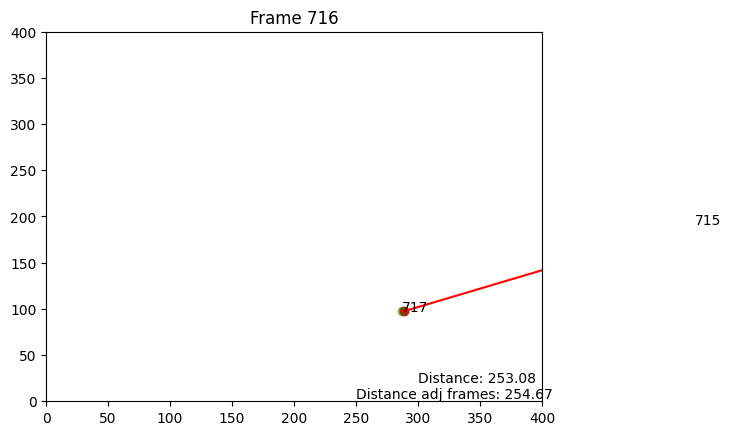

posx and posy should be finite values
posx and posy should be finite values


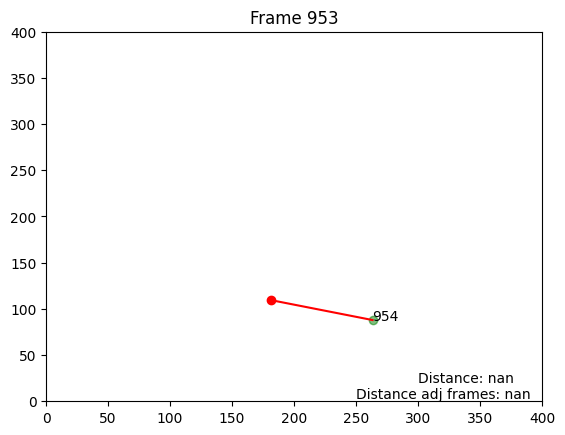

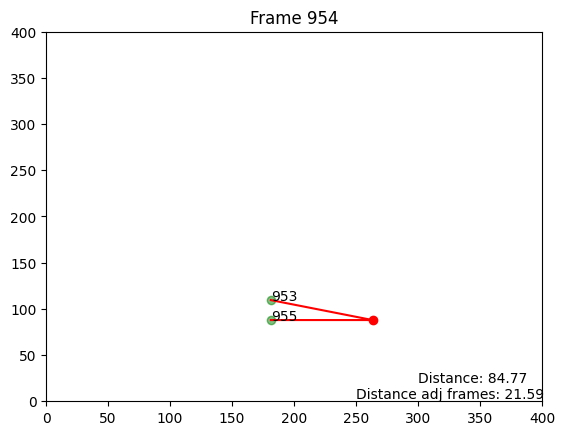

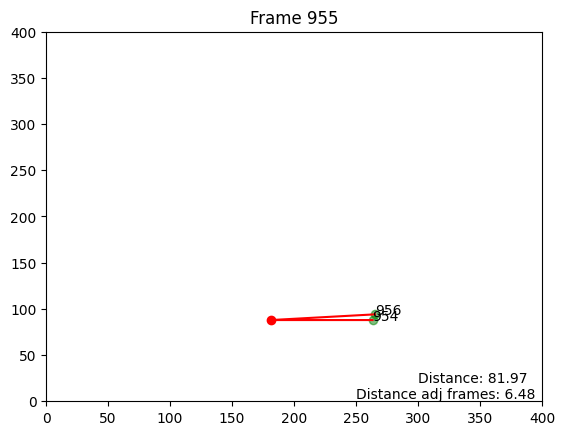

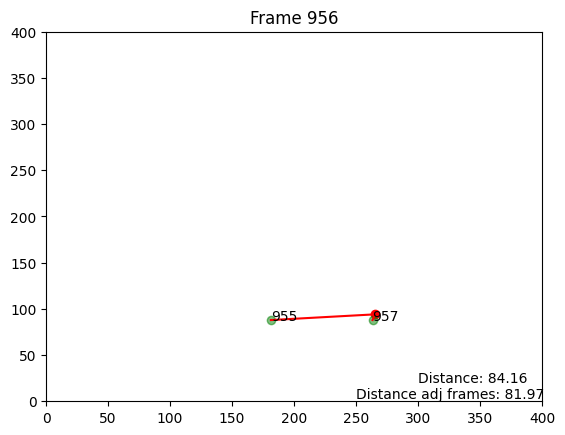

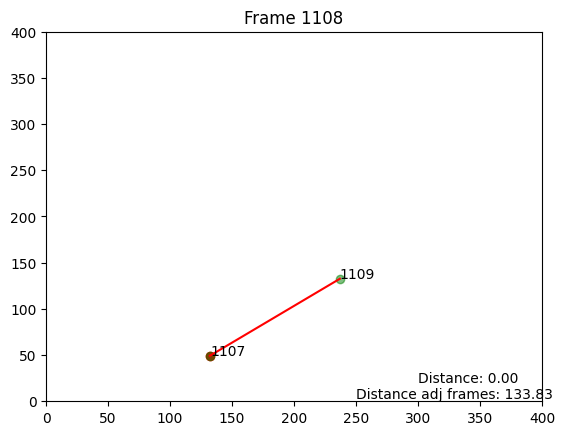

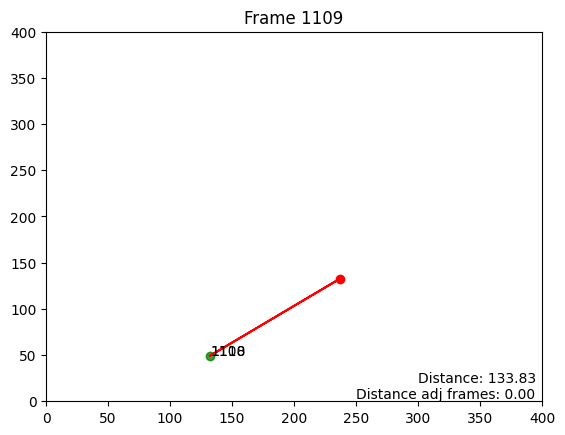

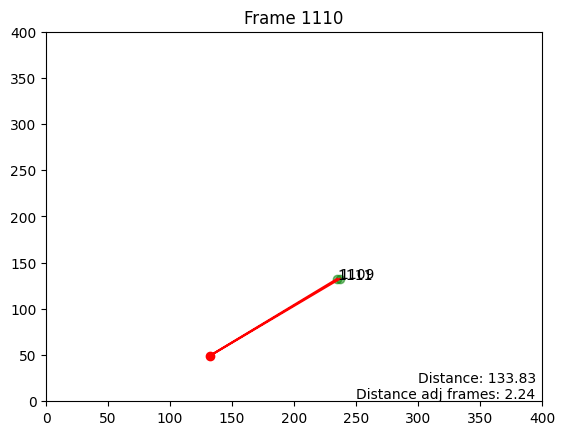

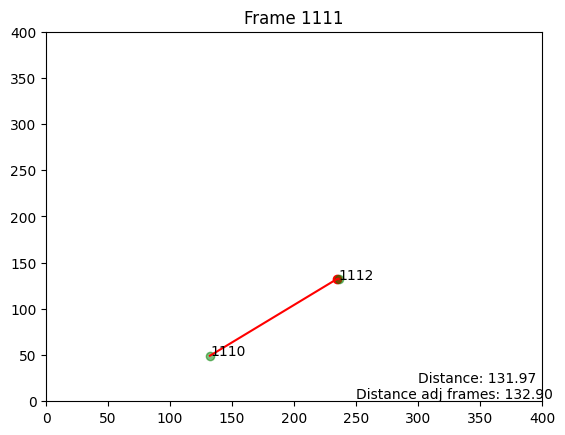

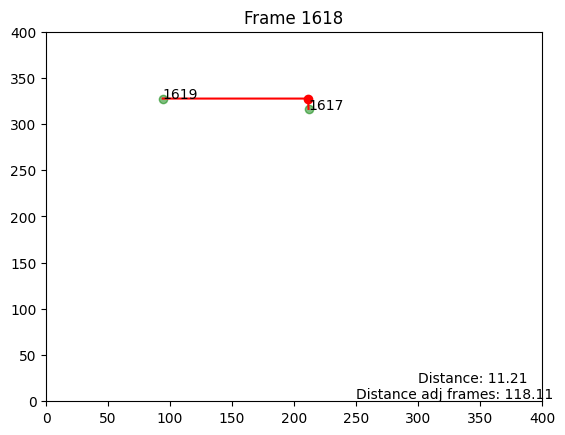

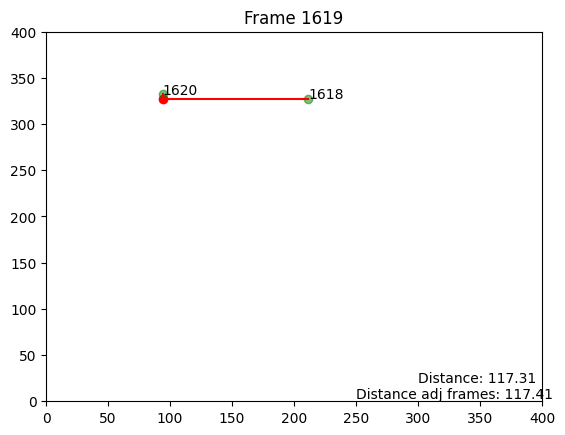

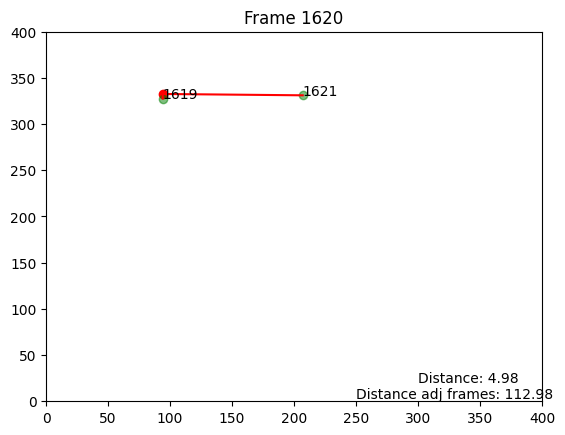

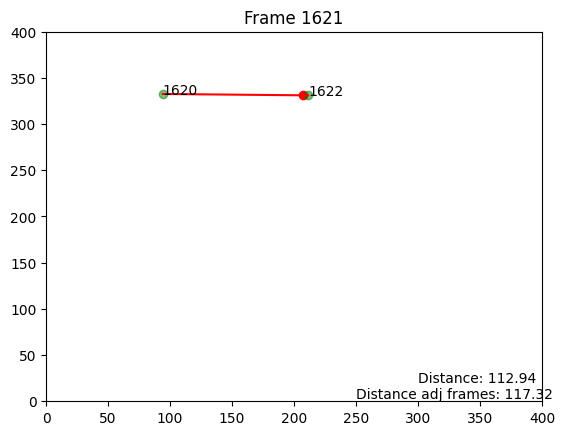

posx and posy should be finite values
posx and posy should be finite values


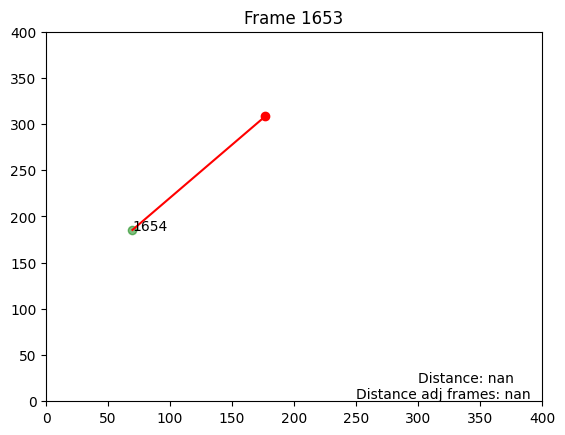

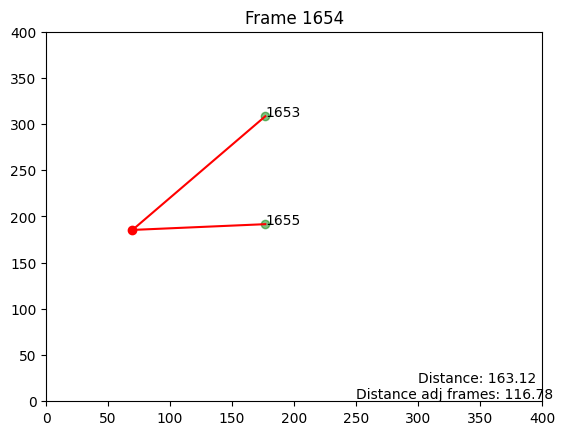

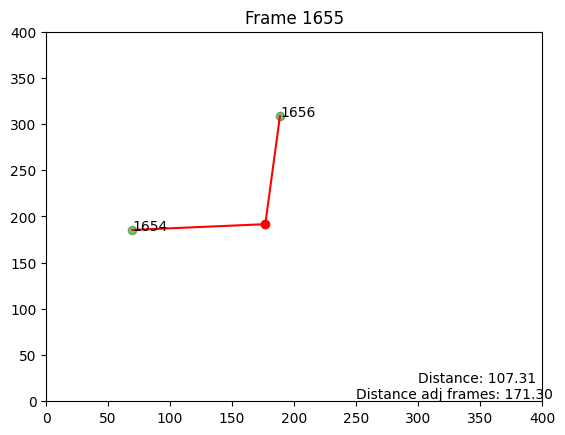

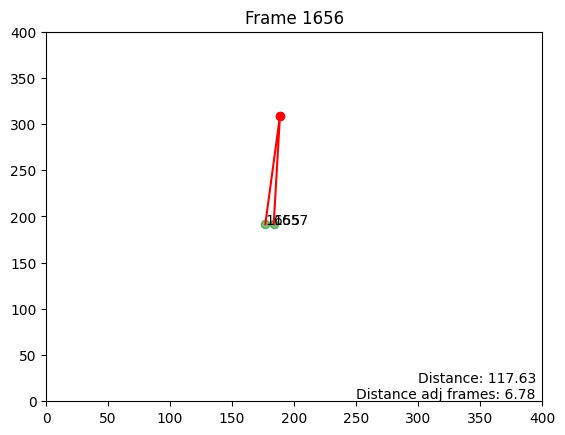

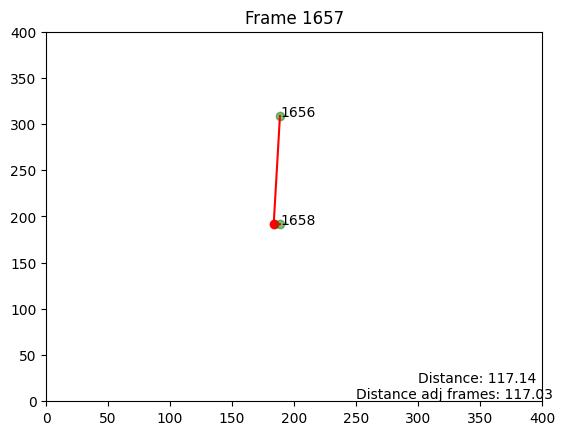

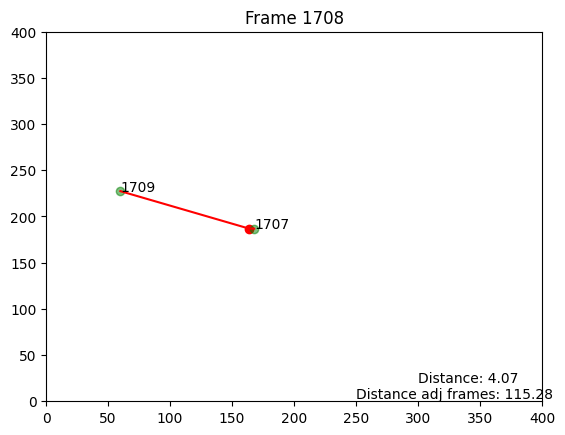

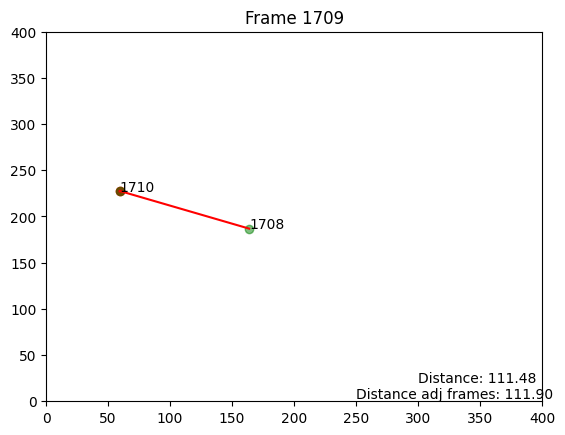

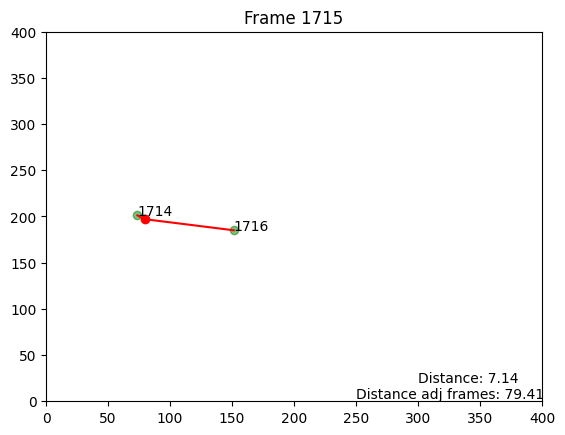

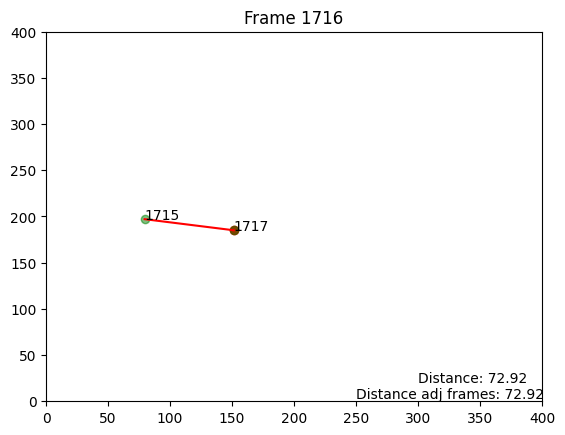

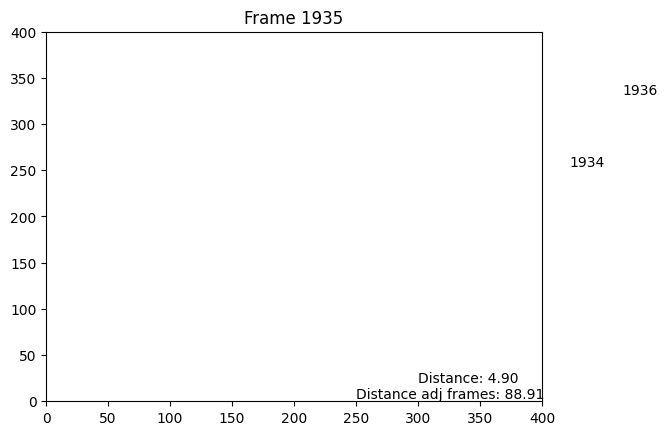

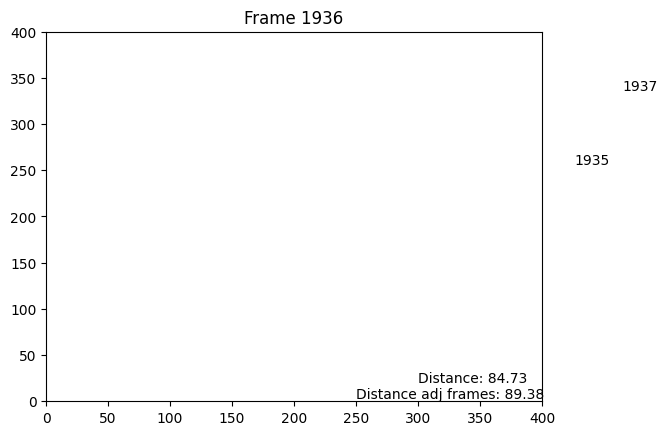

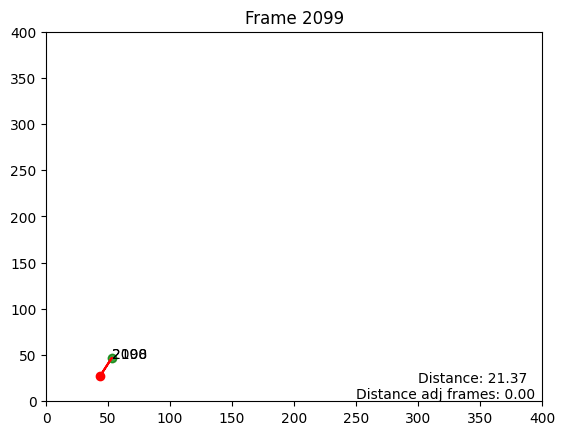

posx and posy should be finite values
posx and posy should be finite values


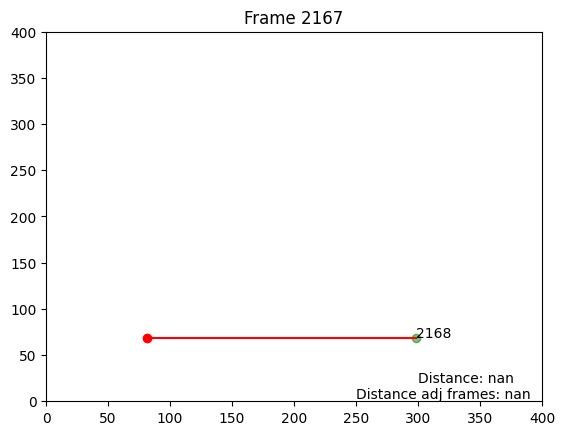

posx and posy should be finite values
posx and posy should be finite values


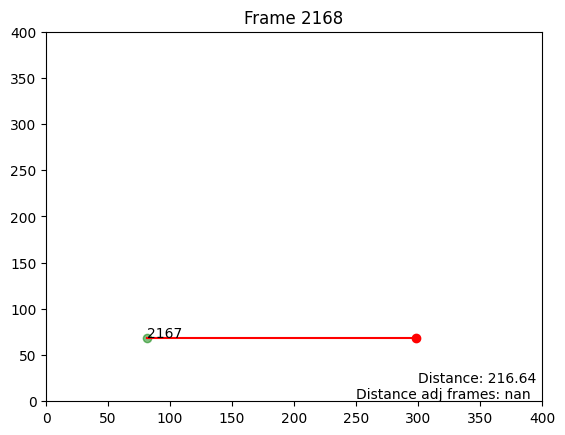

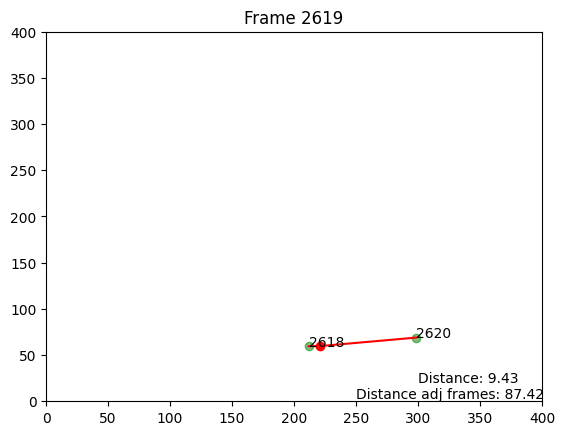

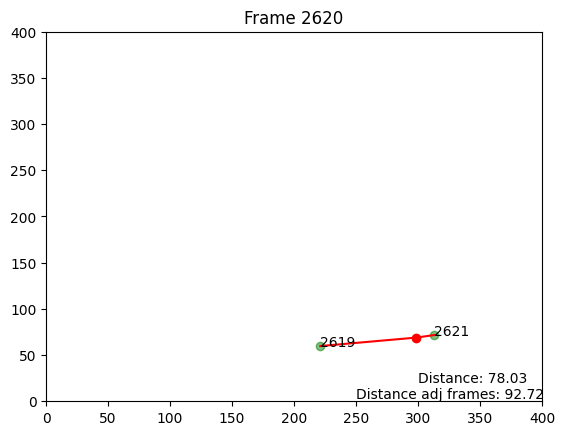

In [329]:

for frame in range(data_dlc.n_frames):
    if jumps[frame]:
        #plt.plot(coords[ind].loc[frame-10:frame+10, (bp, 'x')], coords[ind].loc[frame-10:frame+10, (bp, 'y')], color='blue')
        plt.scatter(coords[ind].loc[frame, (bp, 'x')], coords[ind].loc[frame, (bp, 'y')], color='red')
        plt.scatter(coords[ind].loc[frame-1, (bp, 'x')], coords[ind].loc[frame-1, (bp, 'y')], color='green', alpha=0.5)
        plt.scatter(coords[ind].loc[frame+1, (bp, 'x')], coords[ind].loc[frame+1, (bp, 'y')], color='green', alpha=0.5)
        plt.plot(coords[ind].loc[frame-1:frame+1, (bp, 'x')], coords[ind].loc[frame-1:frame+1, (bp, 'y')], color='red')
        plt.text(250, 3, f"Distance adj frames: {np.sqrt((coords[ind].loc[frame-1, (bp, 'x')] - coords[ind].loc[frame+1, (bp, 'x')])**2 + (coords[ind].loc[frame-1, (bp, 'y')] - coords[ind].loc[frame+1, (bp, 'y')])**2):.2f}")
        plt.text(300, 20, f"Distance: {np.sqrt((coords[ind].loc[frame-1, (bp, 'x')] - coords[ind].loc[frame, (bp, 'x')])**2 + (coords[ind].loc[frame-1, (bp, 'y')] - coords[ind].loc[frame, (bp, 'y')])**2):.2f}")
        # Plot number of frame
        plt.title(f'Frame {frame}')
        plt.text(coords[ind].loc[frame-1, (bp, 'x')], coords[ind].loc[frame-1, (bp, 'y')], str(frame-1))
        plt.text(coords[ind].loc[frame+1, (bp, 'x')], coords[ind].loc[frame+1, (bp, 'y')], str(frame+1))
        plt.ylim(0, 400)
        plt.xlim(0, 400)
        plt.show()


In [ ]:
    if jumps[frame]:
        #plt.plot(coords[ind].loc[frame-10:frame+10, (bp, 'x')], coords[ind].loc[frame-10:frame+10, (bp, 'y')], color='blue')
        plt.scatter(coords[ind].loc[frame, (bp, 'x')], coords[ind].loc[frame, (bp, 'y')], color='red')
        plt.scatter(coords[ind].loc[frame-1, (bp, 'x')], coords[ind].loc[frame-1, (bp, 'y')], color='green')
        plt.scatter(coords[ind].loc[frame+1, (bp, 'x')], coords[ind].loc[frame+1, (bp, 'y')], color='green')
        plt.plot(coords[ind].loc[frame-1:frame+1, (bp, 'x')], coords[ind].loc[frame-1:frame+1, (bp, 'y')], color='red')
        # Plot number of frame
        plt.title(f'Frame {frame}')
        plt.text(coords[ind].loc[frame-1, (bp, 'x')], coords[ind].loc[frame-1, (bp, 'y')], str(frame-1))
        plt.text(coords[ind].loc[frame+1, (bp, 'x')], coords[ind].loc[frame+1, (bp, 'y')], str(frame+1))
        #plt.ylim(0, 500)
        #plt.xlim(0, 500)
        plt.show()
